#Building a neural network to predict antibody V-gene classes from heavy chain sequence embeddings generated by Ablang

A neural network was trained on heavy chain sequence embeddings generated using the Ablang protein language model. The embeddings were used as features to predict heavy chain V-gene usage, determined by ANARCI, an empirical but computationally intensive method to annotate antibody sequences.

The model was trained by using the following approach:

1.   Import/install dependencies
2.   Read in embeddings and associated metadata
3.   Convert heavy chain V-gene metadata to an encoded class label
4.   One-hot encode the class label
5.   Split the embeddings and labels into training, validation and testing sets
6.   Build and train the model using a simple neural network architecture
7.   Validate the model on the validation set, and finally the testing set to ensure no data leak has occured
8.   Save the model


In [ ]:
#@title Mount drive and load libraries { display-mode: "form" }
import os
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt, seaborn as sns

In [ ]:
#@title Read in heavy chain embeddings and metadata
file = 'ablang_embedding_to_vgene.parquet' #included in submission
tensor_df = pd.read_parquet(file)

In [ ]:
#@title Generate encoded labels and one hot encode
tensor_df['labels'] = tensor_df['v_call_heavy'].apply(lambda x: x.split('*')[0])
labels = tensor_df['labels']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(np.unique(labels))
labels_encoded = to_categorical(labels, num_classes=num_classes)

In [ ]:
#@title Split embeddings into training, validation and testing sets
embeddings = tensor_df.iloc[:, :768]
X_train = embeddings.iloc[:35000, :]
y_train = labels_encoded[:35000, :]

X_val = embeddings.iloc[35000:45000, :]
y_val = labels_encoded[35000:45000, :]

X_test = embeddings.iloc[45000:50000,:]
y_test = labels_encoded[45000:50000,:]

In [ ]:
#@title Build and train model
def build_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#build model
model = build_model(X_train.shape[1], num_classes)

#train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
1094/1094 [==============================] - 15s 12ms/step - loss: 0.4532 - accuracy: 0.8822 - val_loss: 0.0315 - val_accuracy: 0.9898
Epoch 2/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0948 - accuracy: 0.9678 - val_loss: 0.0357 - val_accuracy: 0.9812
Epoch 3/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0786 - accuracy: 0.9729 - val_loss: 0.0240 - val_accuracy: 0.9946
Epoch 4/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0818 - accuracy: 0.9721 - val_loss: 0.0280 - val_accuracy: 0.9808
Epoch 5/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0731 - accuracy: 0.9750 - val_loss: 0.0183 - val_accuracy: 0.9968
Epoch 6/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0675 - accuracy: 0.9774 - val_loss: 0.0246 - val_accuracy: 0.9978
Epoch 7/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.0680 - accuracy: 0.9763 - val_loss: 0.0182 -

157/157 [==============================] - 1s 4ms/step
Accuracy: 0.9948

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00       143
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00       101
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00       124
           8       1.00      1.00      1.00        54
           9       1.00      1.00      1.00        35
          10       1.00      1.00      1.00       121
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00        99
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00       150
          15       1.00      1.00     

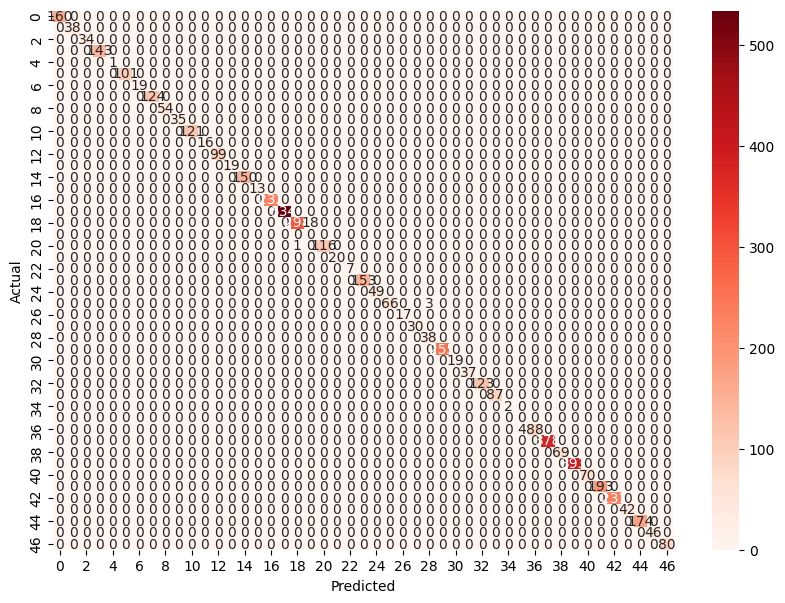

In [ ]:
#@title Assess model on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

157/157 [==============================] - 0s 3ms/step
Accuracy: 0.9648

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       1.00      1.00      1.00       197
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        56
           5       1.00      1.00      1.00        97
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00       180
           8       1.00      1.00      1.00       137
           9       1.00      1.00      1.00        47
          10       1.00      1.00      1.00       115
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00       144
          13       1.00      1.00      1.00        30
          14       1.00      1.00      1.00       157
          15       1.00      1.00      1.00        12
          16       1.00      1.00     

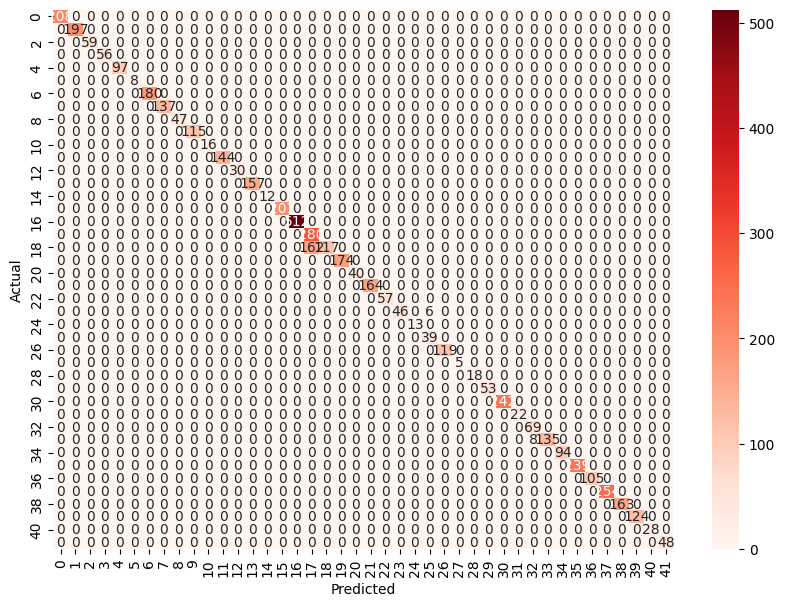

In [ ]:
#@title Assessing the model on totally unseen data

#Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#Basic Metrics
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

#Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/ablang_V_gene_model.h5')